# CNN 2D Classifier Training Example

This notebook demonstrates a 5 layered Multisacle CNN trained to classify spectra from galaxies and galaxies + SNe of several types within 2 weeks (plus/minus) of max light. In this notebook the classifier assumes we can work in the host rest frame.

Required software:
* TensorFlow2
* [desihub software](https://desi.lbl.gov/trac/wiki/Pipeline/GettingStarted/Laptop) (with usual dependencies).

Adding more spectral categories is straightforward.

In [1]:
from glob import glob

import pickle 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import os
import platform

#from astropy.table import Table, vstack, join
#from astropy.io import fits

In [2]:
mpl.rc('font', size=18)

## Input Spectra

Input DESI spectra generated from the pickle notebook. Then divide them into training and test sets for the classifier.

In [3]:
#with open('host_flux.data', 'rb') as filehandle:
#    host_flux = pickle.load(filehandle)
#with open('chunkall-lenssource.data', 'rb') as filehandle:
#    lense_flux = pickle.load(filehandle)

In [4]:
lense_flux=[]
for i in range(0,26):
    with open('lense_spectra{}.data'.format(i), 'rb') as filehandle:
        # read the data as binary data stream
        items=pickle.load(filehandle)
        for i in items:
            lense_flux.append(i)

In [8]:
lense_flux=lense_flux[:1695]

In [9]:
single_flux=[]
for i in range(0,26):
    with open('single_spectra{}.data'.format(i), 'rb') as filehandle:
        # read the data as binary data stream
        items=pickle.load(filehandle)
        for i in items:
            single_flux.append(i)

In [12]:
single_flux=single_flux[:8856]

In [13]:
#with open('chunk002-single.data', 'rb') as filehandle:
    # read the data as binary data stream
 #   single_flux = pickle.load(filehandle)

In [14]:
lense_flux=np.asarray(lense_flux)
single_flux=np.asarray(single_flux)

nlense, nylen, nxlen  = lense_flux.shape
nsingle, nylen, nxlen  = single_flux.shape

nlense, nsingle

(1695, 8856)

### Set up Training Sets and Labels

0. "host" spectra based only on BGS templates
0. "snia" spectra based on BGS + SN Ia templates
0. "snib" spectra based on BGS + SN Ib templates
0. "snic" spectra based on BGS + SN Ic templates
0. "sniin" spectra based on BGS + SN IIn templates
0. "sniip" spectra based on BGS + SN IIP templates

In [15]:
x = np.concatenate([lense_flux, 
                    single_flux
                   ]).reshape(-1,nylen, nxlen, 1)

labels = ['Lense',
          'Single'
         ]
ntypes = len(labels)

# Convert y-label array to appropriate categorical array
from tensorflow.keras.utils import to_categorical

y = to_categorical(
        np.concatenate([np.full(nlense, 0), 
                        np.full(nsingle, 1)
                       ]))

In [16]:
x.shape, y.shape

((10551, 60, 60, 1), (10551, 2))

In [17]:
#snib_flux.shape

### Plot Image to check the CNN's input

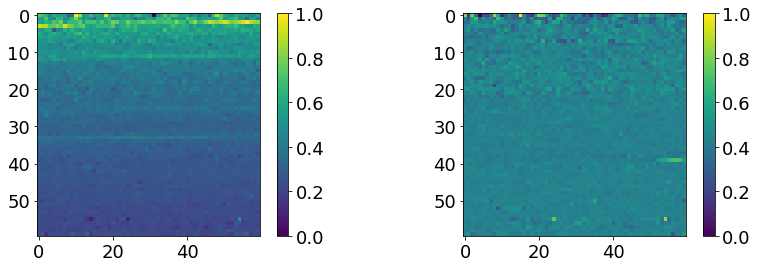

In [18]:
fig = plt.figure(figsize=(14,9))

ax = fig.add_subplot(2, 2, 1)
im = ax.imshow(lense_flux[44])
ax.autoscale(False)
cb = fig.colorbar(im, ax=ax)

ax2 = fig.add_subplot(2, 2, 2, sharex=ax, sharey=ax)
im = ax2.imshow(single_flux[8])
ax2.autoscale(False)
cb = fig.colorbar(im, ax=ax2)

plt.show()

## CNN Network Setup

Train network with TensorFlow+Keras.

In [19]:
#import tensorflow as tf
from tensorflow.keras import utils, regularizers, callbacks, backend
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding1D, BatchNormalization, Flatten, Reshape, Conv2D, MaxPooling2D, Dropout, Add, LSTM, Embedding
from tensorflow.keras.initializers import glorot_normal, glorot_uniform
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping

In [20]:
def network( ncat,input_shape=(60,60,1), learning_rate=1.8225460564333567e-05, reg=0.05, dropout=0.5, seed=None):
    """Define the CNN structure.
    
    Parameters
    ----------
    input_shape : int
        Shape of the input spectra.
    ncat : int
        Number of categories.
    learning_rate : float
        Learning rate.
    reg : float
        Regularization factor.
    dropout : float
        Dropout rate.
    seed : int
        Seed of initializer.
    
    Returns
    -------
    model : tensorflow.keras.Model
        A model instance of the network.
    """
   
    
    
    visible = Input(input_shape, name='Input_Spec1')

    # first feature extractor
    conv1 = Conv2D(28, kernel_size=4, activation='relu',kernel_regularizer=regularizers.l2(reg))(visible)
    X = BatchNormalization(axis=2)(conv1)
    pool1 = MaxPooling2D(pool_size=(3, 3))(X)
    flat1 = Flatten()(pool1)
    
    # second feature extractor
    conv2 = Conv2D(28, kernel_size=8, activation='relu',kernel_regularizer=regularizers.l2(reg))(visible)
    X2 = BatchNormalization(axis=2)(conv2)
    pool2 = MaxPooling2D(pool_size=(3, 3))(X2)
    #conv21=Conv2D(32, kernel_size=8, activation='relu')(pool2)
    flat2 = Flatten()(conv2)
    
    # third feature extractor
    conv3 = Conv2D(28, kernel_size=16, activation='relu',kernel_regularizer=regularizers.l2(reg))(visible)
    X3 = BatchNormalization(axis=2)(conv3)
    pool3 = MaxPooling2D(pool_size=(3, 3))(X3)
    flat3 = Flatten()(pool3)
    
    # Fourth feature extractor
    conv4 = Conv2D(28, kernel_size=32, activation='relu',kernel_regularizer=regularizers.l2(reg))(visible)
    X4 = BatchNormalization(axis=2)(conv4)
    pool4 = MaxPooling2D(pool_size=(3, 3))(X4)
    flat4 = Flatten()(pool4)
    
    # Fifth feature extractor
    conv5 = Conv2D(28, kernel_size=56, activation='relu',kernel_regularizer=regularizers.l2(reg))(visible)
    X5 = BatchNormalization(axis=2)(conv4)
    pool5 = MaxPooling2D(pool_size=(3, 3))(X5)
    flat5 = Flatten()(pool5)
    

    
    # merge feature extractors
    merge = concatenate([flat1, flat2,flat3,flat4,flat5])
    
    # interpretation layer
    hidden1 = Dense(128, activation='relu')(merge)
    droput=Dropout(rate=dropout, seed=seed)(hidden1)
    
  
    
    # prediction output 6
    output = Dense(2, activation='softmax')(droput)
    model = Model(inputs=visible, outputs=output)
    model.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [21]:
model = network(ncat=y.shape[1])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5)

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_Spec1 (InputLayer)        [(None, 60, 60, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 57, 57, 28)   476         Input_Spec1[0][0]                
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 45, 45, 28)   7196        Input_Spec1[0][0]                
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 29, 29, 28)   28700       Input_Spec1[0][0]                
______________________________________________________________________________________________

## Train and Test

Split the data into training and testing (+ validation) samples and fit the network weights.

In [23]:
from sklearn.model_selection import train_test_split

def train_test_validate(x, y, train_size=0.75, test_size=0.125, val_size=0.125):
    # Ensure proper normalization.
    if train_size + test_size + val_size != 1:
        norm = train_size + test_size + val_size
        train_size = train_size/norm
        test_size = test_size/norm
        val_size = val_size/norm
        print('Renormalized to train {:g}, test {:g}, and validate {:g}'.format(train_size, test_size, val_size))
        
    # Split into training and testing samples.
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=1-train_size)
    
    # Split off the validation sample from the test sample.
    x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_size/(test_size+val_size))
    
    return x_train, x_test, x_val, y_train, y_test, y_val

In [24]:
x_train, x_test, x_val, y_train, y_test, y_val = train_test_validate(x, y, 0.6, 0.2, 0.2)



x_train.shape, x_test.shape, x_val.shape

((6330, 60, 60, 1), (2111, 60, 60, 1), (2110, 60, 60, 1))

In [25]:
hist = model.fit(x_train, y_train, batch_size=50, epochs=150, validation_data=(x_test, y_test),callbacks=[es], shuffle=True)

Epoch 1/150
127/127 [==============================] - 43s 340ms/step - loss: 0.8589 - accuracy: 0.8306 - val_loss: 0.9490 - val_accuracy: 0.8423
Epoch 2/150
127/127 [==============================] - 41s 321ms/step - loss: 0.8025 - accuracy: 0.8374 - val_loss: 0.8777 - val_accuracy: 0.8423
Epoch 3/150
127/127 [==============================] - 43s 340ms/step - loss: 0.7727 - accuracy: 0.8374 - val_loss: 0.7851 - val_accuracy: 0.8423
Epoch 4/150
127/127 [==============================] - 41s 325ms/step - loss: 0.7523 - accuracy: 0.8374 - val_loss: 0.7234 - val_accuracy: 0.8423
Epoch 5/150
127/127 [==============================] - 41s 325ms/step - loss: 0.7253 - accuracy: 0.8374 - val_loss: 0.6887 - val_accuracy: 0.8423
Epoch 6/150
127/127 [==============================] - 41s 324ms/step - loss: 0.7069 - accuracy: 0.8374 - val_loss: 0.6718 - val_accuracy: 0.8423
Epoch 7/150
127/127 [==============================] - 42s 329ms/step - loss: 0.6891 - accuracy: 0.8374 - val_loss: 0.6524 -

## Performance

### Loss and Accuracy

Plot loss and accuracy as a function of epoch.

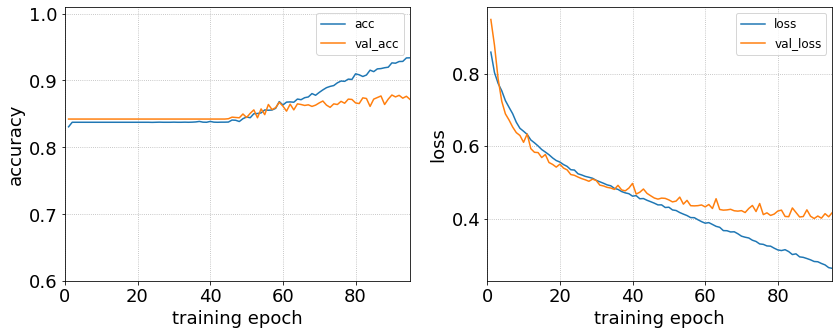

In [26]:
fig, axes = plt.subplots(1,2, figsize=(12,5), sharex=True)

nepoch = len(hist.history['loss'])
epochs = np.arange(1, nepoch+1)

ax = axes[0]
ax.plot(epochs, hist.history['accuracy'], label='acc')
ax.plot(epochs, hist.history['val_accuracy'], label='val_acc')
ax.set(xlabel='training epoch',
       ylabel='accuracy',
       xlim=(0, nepoch),
       ylim=(0.6,1.01)
      )
ax.legend(fontsize=12, loc='best')
ax.grid(ls=':')

ax = axes[1]
ax.plot(epochs, hist.history['loss'], label='loss')
ax.plot(epochs, hist.history['val_loss'], label='val_loss')
ax.set(xlabel='training epoch',
       ylabel='loss',
       xlim=(0, nepoch),
#        ylim=(0.,2.0)
      )
ax.legend(fontsize=12, loc='best')
ax.grid(ls=':')

fig.tight_layout();
fig.savefig('6label_acc_loss5.png', dpi=120)

### ROC Curve and Precision-Recall

Plot both the ROC curves per class and the class-averaged ROC curve.

In [27]:
y_pred = model.predict(x_val)
y_pred

array([[7.5327675e-04, 9.9924672e-01],
       [1.5950412e-01, 8.4049588e-01],
       [3.4991637e-02, 9.6500832e-01],
       ...,
       [4.9855445e-02, 9.5014459e-01],
       [3.0077225e-02, 9.6992278e-01],
       [2.1382174e-03, 9.9786180e-01]], dtype=float32)

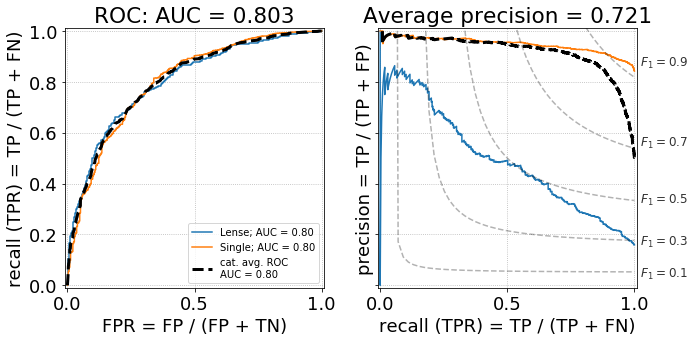

In [28]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

fig, axes = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)

all_fpr = None
all_tpr = None

fpr = dict()
tpr = dict()
pre = dict()
rec = dict()
for i in range(ntypes):
    fpr[i], tpr[i], _ = roc_curve(y_val[:,i], y_pred[:,i])        
    roc_auc = auc(fpr[i], tpr[i])
    
    ax = axes[0]
    ax.plot(fpr[i], tpr[i], label='{}; AUC = {:.2f}'.format(labels[i], roc_auc))
    ax.grid(ls=':')
    
    pre[i], rec[i], _ = precision_recall_curve(y_val[:,i], y_pred[:,i])
    
    ax = axes[1]
    ax.plot(rec[i], pre[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(ntypes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(ntypes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr / ntypes
fpr['macro'] = np.insert(fpr['macro'], 0, 0)
tpr['macro'] = np.insert(tpr['macro'], 0, 0)
roc_auc_macro = auc(fpr['macro'], tpr['macro'])
        
ax = axes[0]
ax.plot(fpr['macro'], tpr['macro'], lw=3, ls='--', color='k',
        label='cat. avg. ROC\nAUC = {:.2f}'.format(roc_auc_macro))
ax.set(xlim=(-0.01,1.01), xlabel='FPR = FP / (FP + TN)',
       ylim=(-0.01,1.01), ylabel='recall (TPR) = TP / (TP + FN)',
       title='ROC: AUC = {:.3f}'.format(roc_auc_macro),
       aspect='equal')
ax.legend(fontsize=10, loc='lower right')

ax = axes[1]
pre['micro'], rec['micro'], _ = precision_recall_curve(y_val.ravel(), y_pred.ravel())
ax.plot(rec['micro'], pre['micro'], lw=3, ls='--', color='k')

f_scores = np.linspace(0.1, 0.9, num=5)
for f_score in f_scores:
    x_ = np.linspace(0.01, 1)
    y_ = f_score * x_ / (2 * x_ - f_score)
    l, = plt.plot(x_[y_ >= 0], y_[y_ >= 0], color='k', ls='--', alpha=0.3)
    ax.annotate(' $F_{{1}}={0:0.1f}$'.format(f_score), xy=(1.01, y_[45]-0.02),
                fontsize=12, alpha=0.8)
ax.grid(ls=':')
ax.set(xlabel='recall (TPR) = TP / (TP + FN)',
       ylabel='precision = TP / (TP + FP)',
       title='Average precision = {:.3f}'.format(average_precision_score(y_val, y_pred)),
       aspect='equal')

fig.tight_layout()
fig.savefig('6label_roc_pr5.png', dpi=120)

### Confusion Matrix

In [29]:
from sklearn.metrics import confusion_matrix

# In the multilabel classifier, test that the maximum of the
# output matrix of values matches.
cm = confusion_matrix(y_val.argmax(axis=1), y_pred.argmax(axis=1))
cmnorm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

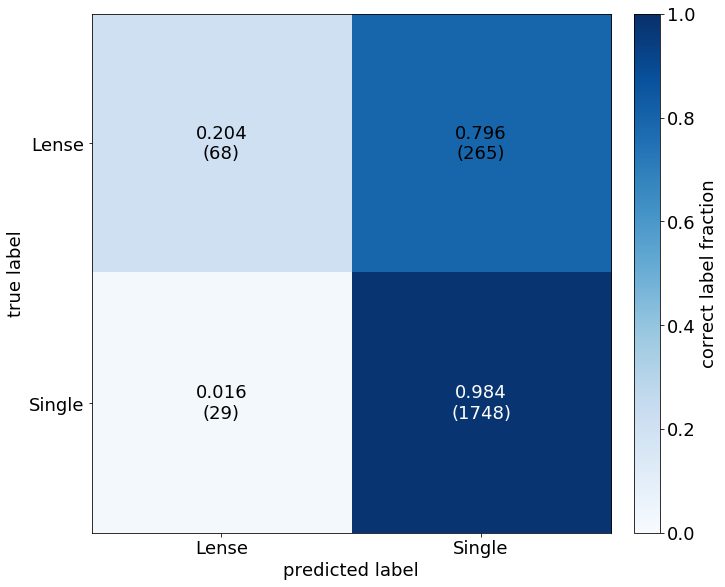

In [30]:
fig, ax = plt.subplots(1,1, figsize=(10,8.5))

im = ax.imshow(cmnorm, cmap='Blues', vmin=0, vmax=1)
cb = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cb.set_label('correct label fraction')

ax.set(aspect='equal',
       xlabel='predicted label',
       xticks=np.arange(cm.shape[1]),
       xticklabels=labels,
       ylabel='true label',
       yticks=np.arange(cm.shape[1]),
       yticklabels=labels)

thresh = 0.5*cm.max()
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, '{:.3f}\n({:d})'.format(cmnorm[i,j], cm[i,j]),
                ha='center', va='center',
                color='black' if cm[i,j] < thresh else 'white')

fig.tight_layout()
fig.savefig('6label_cm_5.png', dpi=120)

In [31]:
model.save('synthlensmodel')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: synthlensmodel/assets


In [32]:
model.save('synthlensmodel.h5')

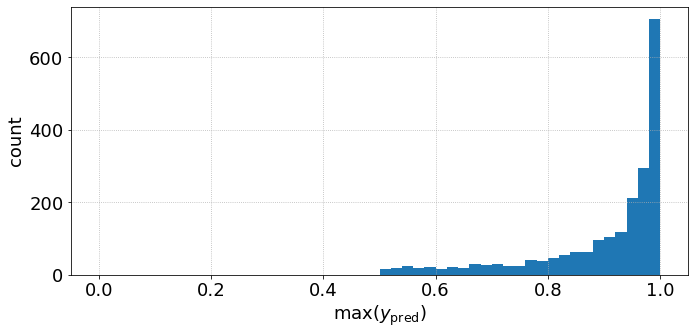

In [33]:
i = np.argmax(y_pred, axis=1)
y_max = np.max(y_pred, axis=1)

fig, ax = plt.subplots(1,1, figsize=(10,5), tight_layout=True)
ax.hist(y_max, bins=np.linspace(0,1,51))
ax.set(xlabel='$\max{(y_\mathrm{pred})}$',
       ylabel='count')
ax.grid(ls=':')
fig.savefig('max_ypred.png', dpi=120)

In [34]:
np.sum(y_max > 0.95) / len(y_max)

0.5265402843601896

In [35]:
select = y_max > 0.99

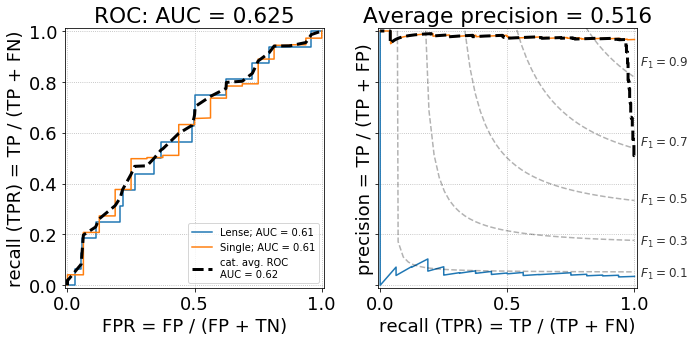

In [36]:
fig, axes = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)

all_fpr = None
all_tpr = None

fpr = dict()
tpr = dict()
pre = dict()
rec = dict()
for i in range(ntypes):
    fpr[i], tpr[i], _ = roc_curve(y_val[select][:,i], y_pred[select][:,i])        
    roc_auc = auc(fpr[i], tpr[i])
    
    ax = axes[0]
    ax.plot(fpr[i], tpr[i], label='{}; AUC = {:.2f}'.format(labels[i], roc_auc))
    ax.grid(ls=':')
    
    pre[i], rec[i], _ = precision_recall_curve(y_val[select][:,i], y_pred[select][:,i])
    
    ax = axes[1]
    ax.plot(rec[i], pre[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(ntypes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(ntypes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr / ntypes
fpr['macro'] = np.insert(fpr['macro'], 0, 0)
tpr['macro'] = np.insert(tpr['macro'], 0, 0)
roc_auc_macro = auc(fpr['macro'], tpr['macro'])
        
ax = axes[0]
ax.plot(fpr['macro'], tpr['macro'], lw=3, ls='--', color='k',
        label='cat. avg. ROC\nAUC = {:.2f}'.format(roc_auc_macro))
ax.set(xlim=(-0.01,1.01), xlabel='FPR = FP / (FP + TN)',
       ylim=(-0.01,1.01), ylabel='recall (TPR) = TP / (TP + FN)',
       title='ROC: AUC = {:.3f}'.format(roc_auc_macro),
       aspect='equal')
ax.legend(fontsize=10, loc='lower right')

ax = axes[1]
pre['micro'], rec['micro'], _ = precision_recall_curve(y_val[select].ravel(), y_pred[select].ravel())
ax.plot(rec['micro'], pre['micro'], lw=3, ls='--', color='k')

f_scores = np.linspace(0.1, 0.9, num=5)
for f_score in f_scores:
    x_ = np.linspace(0.01, 1)
    y_ = f_score * x_ / (2 * x_ - f_score)
    l, = plt.plot(x_[y_ >= 0], y_[y_ >= 0], color='k', ls='--', alpha=0.3)
    ax.annotate(' $F_{{1}}={0:0.1f}$'.format(f_score), xy=(1.01, y_[45]-0.02),
                fontsize=12, alpha=0.8)
ax.grid(ls=':')
ax.set(xlabel='recall (TPR) = TP / (TP + FN)',
       ylabel='precision = TP / (TP + FP)',
       title='Average precision = {:.3f}'.format(average_precision_score(y_val[select], y_pred[select])),
       aspect='equal')

fig.tight_layout()
fig.savefig('6label_roc_pr_y99_5.png', dpi=120)

In [37]:
# In the multilabel classifier, test that the maximum of the
# output matrix of values matches.
cm = confusion_matrix(y_val[select].argmax(axis=1), y_pred[select].argmax(axis=1))
cmnorm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

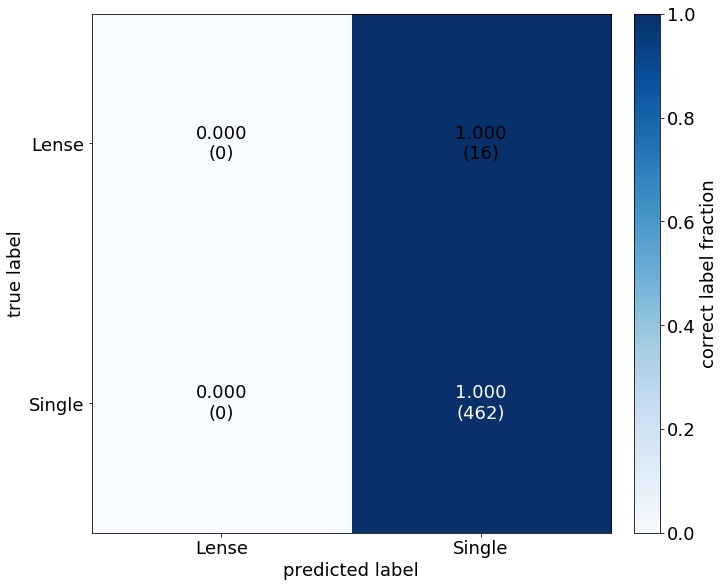

In [38]:
fig, ax = plt.subplots(1,1, figsize=(10,8.5))

im = ax.imshow(cmnorm, cmap='Blues', vmin=0, vmax=1)
cb = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cb.set_label('correct label fraction')

ax.set(aspect='equal',
       xlabel='predicted label',
       xticks=np.arange(cm.shape[1]),
       xticklabels=labels,
       ylabel='true label',
       yticks=np.arange(cm.shape[1]),
       yticklabels=labels)

# thresh = 0.5*cm.max()
thresh = np.average(cm)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, '{:.3f}\n({:d})'.format(cmnorm[i,j], cm[i,j]),
                ha='center', va='center',
                color='black' if cm[i,j] < thresh else 'white')

fig.tight_layout()
fig.savefig('6label_cm_ygt0.99_5.png', dpi=120)

In [39]:
len(y_pred), len(y_pred) - np.sum(select)

(2110, 1632)

In [40]:
import tensorflow
from tensorflow import keras
reconstructed_model = tensorflow.keras.models.load_model('synthlensmodel.h5')

In [41]:
import pickle 
import numpy as np

with open('too_20210708.data', 'rb') as filehandle:
    too_data = pickle.load(filehandle)

too_data = np.asarray(too_data)
# reconstructed_model.predict(too_data)

#### Run the TensorFlow Model on the Data

In [42]:
y_pred = reconstructed_model.predict(too_data)

#### Get the Prediction

The `argmax` function will return which label gets the highest probability. We'll choose this as the correct label. The labels should correspond to:
* 0: strong lens candidate
* 1: single galaxy

(array([ 183.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        3117.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

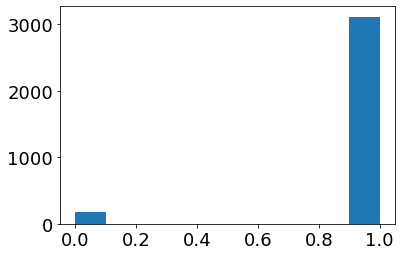

In [43]:
labels = y_pred.argmax(axis=1)
plt.hist(labels)

In [44]:
def countOf(labels, x):
    count = 0
    for element in labels:
        if (element == x):
            count = count + 1
    return count

In [45]:
countOf(labels,0)

183

In [46]:
countOf(labels,1)

3117

In [47]:
len(labels)

3300

#### Simple Check: Simulated Data

In [48]:
y_pred = reconstructed_model.predict(single_flux)

(array([  72.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        8784.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

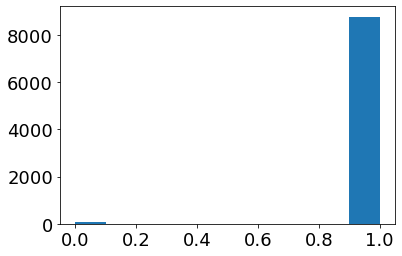

In [49]:
labels = y_pred.argmax(axis=1)
plt.hist(labels)

In [50]:
y_pred = reconstructed_model.predict(lense_flux)

(array([752.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 943.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

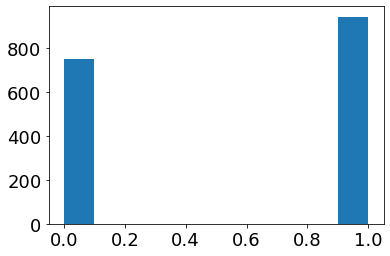

In [51]:
labels = y_pred.argmax(axis=1)
plt.hist(labels)

Shows that it is not likely to give false positives, more likely to give a false negative.

In [123]:
countOf(labels,0)/countOf(labels,1)

0.013923238985069157